In [1]:
import keras
from keras.models import Sequential, Model, load_model

import os
import pickle
import numpy as np
import pandas as pd

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

from scrambler.models import *
from scrambler.utils import OneHotEncoder, get_sequence_masks
from scrambler.visualizations import plot_protein_logo, plot_protein_importance_scores

from ppi_utils import load_ppi_data, load_ppi_predictor, animate_ppi_example


Using TensorFlow backend.


In [ ]:
#Load PPI data and predictor

seq_length = 81

residue_map = {'D': 0, 'E': 1, 'V': 2, 'K': 3, 'R': 4, 'L': 5, 'S': 6, 'T': 7, 'N': 8, 'H': 9, 'A': 10, 'I': 11, 'G': 12, 'P': 13, 'Q': 14, 'Y': 15, 'W': 16, 'M': 17, 'F': 18, '#': 19}

encoder = OneHotEncoder(seq_length, residue_map)

data_path = '../analysis/coiled_coil_binders/pair_df_baker_big_set_5x_negatives_in_shuffled.csv'

x_1_train, x_2_train, l_1_train, l_2_train, y_train, x_1_test, x_2_test, l_1_test, l_2_test, y_test = load_ppi_data(data_path, encoder, n_train_pos=20000, n_train_neg=20000, n_test_pos=2000, n_test_neg=2000)

predictor_path = '../analysis/coiled_coil_binders/saved_models/ppi_rnn_baker_big_set_5x_negatives_classifier_symmetric_drop_25_5x_negatives_balanced_partitioned_data_epoch_10.h5'

predictor = load_ppi_predictor(predictor_path)


In [3]:
#Define sequence template and background

#Define sequence templates

sequence_templates = [
    '$' * i + '#' * (seq_length - i)
    for i in range(seq_length+1)
]

onehot_templates = [encoder(sequence_template)[None, ...] for sequence_template in sequence_templates]

sequence_masks = [
    np.array([1 if sequence_templates[i][j] == '$' else 0 for j in range(len(sequence_templates[i]))])
    for i in range(seq_length+1)
]

#Calculate background distributions

pseudo_count = 0.1

x_means = []
for i in range(seq_length + 1) :
    x_train_len = x_1_train[np.ravel(l_1_train) == i, ...]
    
    if x_train_len.shape[0] > 0 :
        x_mean_len = (np.sum(x_train_len, axis=(0, 1)) + pseudo_count) / (np.sum(x_train_len, axis=(0, 1, 3)).reshape(-1, 1) + 20. * pseudo_count)
        x_means.append(x_mean_len)
    else :
        x_means.append(np.ones((x_1_train.shape[2], x_1_train.shape[3])))


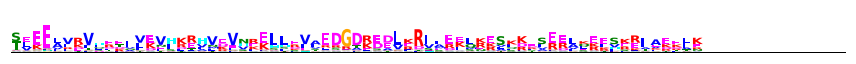

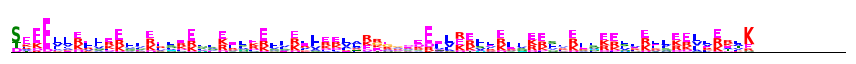

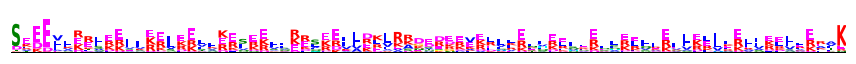

In [4]:
#Visualize a few background sequence distributions

visualize_len = 67

plot_protein_logo(residue_map, np.copy(x_means[visualize_len]), sequence_template=sequence_templates[visualize_len], figsize=(12, 1), logo_height=1.0, plot_start=0, plot_end=81)

visualize_len = 72

plot_protein_logo(residue_map, np.copy(x_means[visualize_len]), sequence_template=sequence_templates[visualize_len], figsize=(12, 1), logo_height=1.0, plot_start=0, plot_end=81)

visualize_len = 81

plot_protein_logo(residue_map, np.copy(x_means[visualize_len]), sequence_template=sequence_templates[visualize_len], figsize=(12, 1), logo_height=1.0, plot_start=0, plot_end=81)


In [4]:
#Calculate mean training set kl-divergence against background

mean_kl_divs = []

for i in range(seq_length + 1) :
    x_train_len = x_1_train[np.ravel(l_1_train) == i, ...]
    
    if x_train_len.shape[0] > 0 :
        x_train_clipped_len = np.clip(np.copy(x_train_len[:, 0, :, :]), 1e-8, 1. - 1e-8)

        kl_divs = np.sum(x_train_clipped_len * np.log(x_train_clipped_len / np.tile(np.expand_dims(x_means[i], axis=0), (x_train_clipped_len.shape[0], 1, 1))), axis=-1) / np.log(2.0)

        x_mean_kl_divs = np.sum(kl_divs * sequence_masks[i], axis=-1) / np.sum(sequence_masks[i])
        x_mean_kl_div = np.mean(x_mean_kl_divs)

        mean_kl_divs.append(x_mean_kl_div)
        
        print("[Length = " + str(i) + "] Mean KL Div against background (bits) = " + str(x_mean_kl_div))
    else :
        mean_kl_divs.append(0)


[Length = 67] Mean KL Div against background (bits) = 1.8338768041146942
[Length = 68] Mean KL Div against background (bits) = 2.5460477414577154
[Length = 69] Mean KL Div against background (bits) = 2.6963265731207375
[Length = 70] Mean KL Div against background (bits) = 2.614518136782641
[Length = 71] Mean KL Div against background (bits) = 2.651062021646643
[Length = 72] Mean KL Div against background (bits) = 2.692262963282262
[Length = 73] Mean KL Div against background (bits) = 2.664524444653306
[Length = 74] Mean KL Div against background (bits) = 2.734017249859557
[Length = 75] Mean KL Div against background (bits) = 2.6117448338622578
[Length = 76] Mean KL Div against background (bits) = 2.6657638687763283
[Length = 77] Mean KL Div against background (bits) = 2.6718047213385736
[Length = 78] Mean KL Div against background (bits) = 2.641879650352336
[Length = 79] Mean KL Div against background (bits) = 2.6207788735288795
[Length = 80] Mean KL Div against background (bits) = 2.6

In [5]:
#Build scrambler

#Scrambler network configuration
network_config = {
    'n_groups' : 5,
    'n_resblocks_per_group' : 4,
    'n_channels' : 32,
    'window_size' : 3,
    'dilation_rates' : [1, 2, 4, 2, 1],
    'drop_rate' : 0.0,
    'norm_mode' : 'instance',
    'mask_smoothing' : False,
    'mask_smoothing_window_size' : 5,
    'mask_smoothing_std' : 1.,
    'mask_drop_scales' : [1, 5],
    'mask_min_drop_rate' : 0.0,
    'mask_max_drop_rate' : 0.5,
    'label_input' : False
}

#Initialize scrambler
scrambler = Scrambler(
    n_inputs=2,
    multi_input_mode='siamese',
    scrambler_mode='occlusion',
    input_size_x=1,
    input_size_y=81,
    n_out_channels=20,
    input_templates=onehot_templates,
    input_backgrounds=x_means,
    batch_size=32,
    n_samples=32,
    sample_mode='gumbel',
    zeropad_input=True,
    mask_dropout=False,
    network_config=network_config
)


In [6]:
#Train scrambler

n_epochs = 10

train_history = scrambler.train(
    predictor,
    [x_1_train, x_2_train],
    y_train,
    [x_1_test, x_2_test],
    y_test,
    n_epochs,
    group_train=[l_1_train, l_2_train],
    group_test=[l_1_test, l_2_test],
    monitor_test_indices=np.arange(32).tolist(),
    monitor_batch_freq_dict={0 : 1, 100 : 5, 1250 : 10},
    nll_mode='reconstruction',
    predictor_task='classification',
    reference='label',
    entropy_mode='target',
    entropy_bits=2.4,
    entropy_weight=1.
)


Train on 40000 samples, validate on 4000 samples
Epoch 1/10
40000/40000 [==============================] - 679s 17ms/step - loss: 2.1750 - nll_loss: 1.9488 - entropy_loss: 0.2262 - val_loss: 1.8926 - val_nll_loss: 1.7581 - val_entropy_loss: 0.1345
Epoch 2/10
40000/40000 [==============================] - 611s 15ms/step - loss: 1.8592 - nll_loss: 1.6930 - entropy_loss: 0.1662 - val_loss: 1.7187 - val_nll_loss: 1.5377 - val_entropy_loss: 0.1810
Epoch 3/10
40000/40000 [==============================] - 612s 15ms/step - loss: 1.7481 - nll_loss: 1.5879 - entropy_loss: 0.1602 - val_loss: 1.6377 - val_nll_loss: 1.4842 - val_entropy_loss: 0.1536
Epoch 4/10
40000/40000 [==============================] - 610s 15ms/step - loss: 1.6883 - nll_loss: 1.5327 - entropy_loss: 0.1556 - val_loss: 1.6318 - val_nll_loss: 1.5114 - val_entropy_loss: 0.1205
Epoch 5/10
40000/40000 [==============================] - 621s 16ms/step - loss: 1.6587 - nll_loss: 1.5055 - entropy_loss: 0.1531 - val_loss: 1.5849 - val_

In [7]:
#Save scrambler checkpoint
save_dir = 'saved_models'

model_name = 'ppi_occlusion_scrambler_bits_24_epochs_10_label'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

model_path = os.path.join(save_dir, model_name + '.h5')

scrambler.save_model(model_path)

#Sub-select train history monitor (one example only) to save space
for t in range(len(train_history['monitor_pwms'])) :
    for k in range(len(train_history['monitor_pwms'][t])) :
        train_history['monitor_pwms'][t][k] = train_history['monitor_pwms'][t][k][0:1, ...]
        train_history['monitor_importance_scores'][t][k] = train_history['monitor_importance_scores'][t][k][0:1, ...]

    train_history['monitor_nll_losses'][t] = train_history['monitor_nll_losses'][t][0:1, ...]
    train_history['monitor_entropy_losses'][t] = train_history['monitor_entropy_losses'][t][0:1, ...]

pickle.dump({'train_history' : train_history}, open(save_dir + '/' + model_name + '_train_history.pickle', 'wb'))


Saved scrambler model at saved_models/ppi_occlusion_scrambler_bits_24_epochs_10_label.h5 


In [6]:
#Load models
save_dir = 'saved_models'

model_name = 'ppi_occlusion_scrambler_bits_24_epochs_10_label'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

model_path = os.path.join(save_dir, model_name + '.h5')

scrambler.load_model(model_path)


Loaded scrambler model from saved_models/ppi_occlusion_scrambler_bits_24_epochs_10_label.h5 


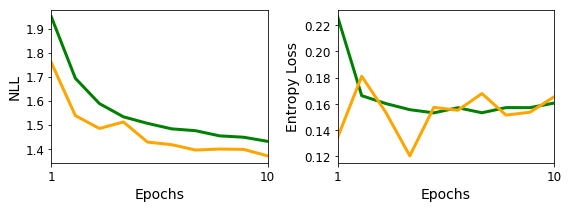

In [9]:
#Plot training statistics

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(2 * 4, 3))

n_epochs_actual = len(train_history['nll_loss'])

ax1.plot(np.arange(1, n_epochs_actual + 1), train_history['nll_loss'], linewidth=3, color='green')
ax1.plot(np.arange(1, n_epochs_actual + 1), train_history['val_nll_loss'], linewidth=3, color='orange')

plt.sca(ax1)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("NLL", fontsize=14)
plt.xlim(1, n_epochs_actual)
plt.xticks([1, n_epochs_actual], [1, n_epochs_actual], fontsize=12)
plt.yticks(fontsize=12)

ax2.plot(np.arange(1, n_epochs_actual + 1), train_history['entropy_loss'], linewidth=3, color='green')
ax2.plot(np.arange(1, n_epochs_actual + 1), train_history['val_entropy_loss'], linewidth=3, color='orange')

plt.sca(ax2)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Entropy Loss", fontsize=14)
plt.xlim(1, n_epochs_actual)
plt.xticks([1, n_epochs_actual], [1, n_epochs_actual], fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()

plt.show()


In [7]:
#Interpret the test set using the trained scrambler

[pwm_1_test, pwm_2_test], [sample_1_test, sample_2_test], [importance_scores_1_test, importance_scores_2_test] = scrambler.interpret([x_1_test, x_2_test], group=[l_1_test, l_2_test])


4000/4000 [==============================] - 10s 3ms/step


Test pair 0:
 - Prediction (original) = 0.85
 - Predictions (scrambled) = [0.44, 0.01, 0.63, 0.59, 0.46, 0.79, 0.43, 0.4, 0.56, 0.64, 0.67, 0.19, 0.02, 0.65, 0.0, 0.15, 0.73, 0.53, 0.18, 0.17, 0.23, 0.32, 0.39, 0.02, 0.29, 0.36, 0.07, 0.57, 0.04, 0.17, 0.12, 0.26]
Binder 1:


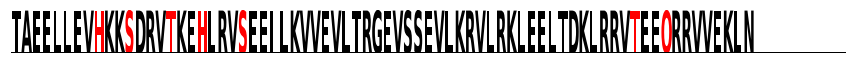

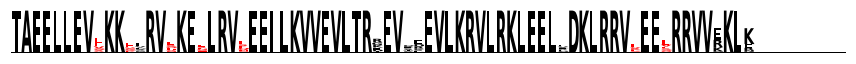

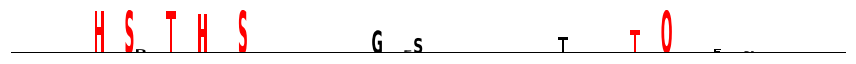

Binder 2:


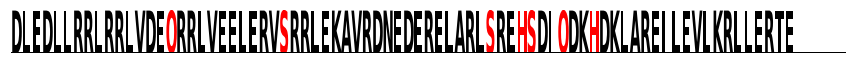

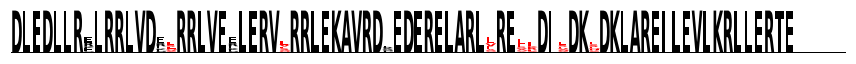

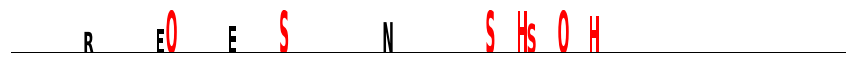

In [11]:
#Visualize a few reconstructed sequence patterns

#Color by ground truth hbnet positions for test pair 0
special_sequence_template_1 = ("TAEELLEV$KK$DRV$KE$LRV$EEILKVVEVLTRGEVSSEVLKRVLRKLEELTDKLRRV$EE$RRVVEKLN" + "#" * 81)[:81]
special_sequence_template_2 = ("DLEDLLRRLRRLVDE$RRLVEELERV$RRLEKAVRDNEDERELARL$RE$$DI$DK$DKLAREILEVLKRLLERTE" + "#" * 81)[:81]

score_quantile = 0.95

plot_examples = [0]
save_examples = []

for test_ix in plot_examples :
    
    pwm_1_curr = pwm_1_test[test_ix:test_ix+1, ...] * sequence_masks[l_1_test[test_ix, 0]][None, None, :, None]
    pwm_2_curr = pwm_2_test[test_ix:test_ix+1, ...] * sequence_masks[l_2_test[test_ix, 0]][None, None, :, None]
    
    importance_scores_1_curr = importance_scores_1_test[test_ix:test_ix+1, ...] * sequence_masks[l_1_test[test_ix, 0]][None, None, :, None]
    importance_scores_2_curr = importance_scores_2_test[test_ix:test_ix+1, ...] * sequence_masks[l_2_test[test_ix, 0]][None, None, :, None]
    
    print("Test pair " + str(test_ix) + ":")
    
    y_test_hat_ref = predictor.predict(x=[x_1_test[test_ix:test_ix+1, ...], x_2_test[test_ix:test_ix+1, ...]], batch_size=1)[0, 0]
    y_test_hat = predictor.predict(x=[sample_1_test[test_ix, ...], sample_2_test[test_ix, ...]], batch_size=32)[:32, 0].tolist()
    
    print(" - Prediction (original) = " + str(round(y_test_hat_ref, 2))[:4])
    print(" - Predictions (scrambled) = " + str([float(str(round(y_test_hat[i], 2))[:4]) for i in range(len(y_test_hat))]))
    
    save_figs = False
    if save_examples is not None and test_ix in save_examples :
        save_figs = True
    
    sequence_template_1 = sequence_templates[l_1_test[test_ix, 0]]
    sequence_template_2 = sequence_templates[l_2_test[test_ix, 0]]
    if special_sequence_template_1 is not None :
        sequence_template_1 = special_sequence_template_1
        sequence_template_2 = special_sequence_template_2
    
    q_1 = np.quantile(importance_scores_1_curr[0, 0, :, :], q=score_quantile)
    q_2 = np.quantile(importance_scores_2_curr[0, 0, :, :], q=score_quantile)
    
    seq_1 = encoder.decode(x_1_test[test_ix, 0, :, :])[:l_1_test[test_ix, 0]]
    seq_2 = encoder.decode(x_2_test[test_ix, 0, :, :])[:l_2_test[test_ix, 0]]
    
    print("Binder 1:")

    plot_protein_logo(residue_map, x_1_test[test_ix, 0, :, :], sequence_template=sequence_template_1.replace('#', '@'), color_reference=['red'], sequence_colors=np.zeros(81, dtype=np.int).tolist(), figsize=(12, 1), plot_start=0, plot_end=81, save_figs=save_figs, fig_name=model_name + "_test_ix_" + str(test_ix) + "_orig_sequence_binder_1")
    plot_protein_logo(residue_map, pwm_1_curr[0, 0, :, :], sequence_template=sequence_template_1.replace('#', '@'), color_reference=['red'], sequence_colors=np.zeros(81, dtype=np.int).tolist(), figsize=(12, 1), plot_start=0, plot_end=81, save_figs=save_figs, fig_name=model_name + "_test_ix_" + str(test_ix) + "_scrambld_pwm_binder_1")
    plot_protein_importance_scores(importance_scores_1_curr[0, 0, :, :].T, seq_1, figsize=(12, 1), score_clip=q_1, sequence_template=sequence_template_1, single_color='red', fixed_sequence_template_scores=False, plot_start=0, plot_end=81, save_figs=save_figs, fig_name=model_name + "_test_ix_" + str(test_ix) + "_scores_binder_1")

    print("Binder 2:")

    plot_protein_logo(residue_map, x_2_test[test_ix, 0, :, :], sequence_template=sequence_template_2.replace('#', '@'), color_reference=['red'], sequence_colors=np.zeros(81, dtype=np.int).tolist(), figsize=(12, 1), plot_start=0, plot_end=81, save_figs=save_figs, fig_name=model_name + "_test_ix_" + str(test_ix) + "_orig_sequence_binder_2")
    plot_protein_logo(residue_map, pwm_2_curr[0, 0, :, :], sequence_template=sequence_template_2.replace('#', '@'), color_reference=['red'], sequence_colors=np.zeros(81, dtype=np.int).tolist(), figsize=(12, 1), plot_start=0, plot_end=81, save_figs=save_figs, fig_name=model_name + "_test_ix_" + str(test_ix) + "_scrambld_pwm_binder_2")
    plot_protein_importance_scores(importance_scores_2_curr[0, 0, :, :].T, seq_2, figsize=(12, 1), score_clip=q_2, sequence_template=sequence_template_2, single_color='red', fixed_sequence_template_scores=False, plot_start=0, plot_end=81, save_figs=save_figs, fig_name=model_name + "_test_ix_" + str(test_ix) + "_scores_binder_2")
